####  **Import Required Libraries**

In [689]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### **Load Data**

In [690]:
file_path = "../resources/data/output/online_retail_rfm_kmeans.csv"
df = pd.read_csv(file_path)

In [691]:
df.head()

,CustomerID,Frequency,Monetary,Recency,XformRecency,XformFrequency,XformMonetary,RFM
0,12347.0,182,4310.00,40,-0.150000,1.740741,1.106371,230.368925
1,12348.0,31,1797.24,76,0.107143,-0.123457,0.586978,114.494564
2,12349.0,73,1757.55,19,-0.300000,0.395062,0.573720,99.472245
3,12350.0,17,334.40,311,1.785714,-0.296296,-0.410532,333.815324
4,12352.0,85,2506.04,73,0.085714,0.543210,0.784369,165.826858


In [692]:
df.shape

(4337, 8)

In [693]:
# Select columns including 'CustomerID' from the DataFrame
df_with_customer_id = df[['CustomerID', 'XformRecency', 'XformFrequency', 'XformMonetary']]

# Select RFM-related columns from the DataFrame without 'CustomerID'
rfm_df = df[['XformRecency', 'XformFrequency', 'XformMonetary']]

# Display the first few rows of the RFM DataFrame
rfm_df.head()


,XformRecency,XformFrequency,XformMonetary
0,-0.150000,1.740741,1.106371
1,0.107143,-0.123457,0.586978
2,-0.300000,0.395062,0.573720
3,1.785714,-0.296296,-0.410532
4,0.085714,0.543210,0.784369


In [694]:
rfm_df.shape

(4337, 3)

#####  **KMeans Clustering**

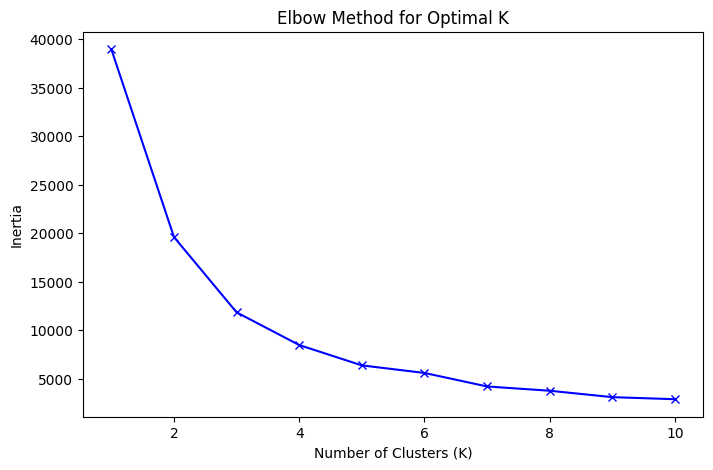

In [695]:
# Elbow Method

# Initialize an empty list to store inertia values for each k
inertia = []

# Define the range for the number of clusters to test, from 1 to 10
K = range(1, 11)

# Iterate over each value of k in the defined range
for k in K:
    # Initialize the KMeans algorithm with the current number of clusters and a fixed random state
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the KMeans model on the RFM DataFrame
    kmeans.fit(rfm_df)
    
    # Append the calculated inertia (sum of squared distances to closest cluster center) to the list
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method results using matplotlib
plt.figure(figsize=(8, 5))   
plt.plot(K, inertia, 'bx-')   
plt.xlabel('Number of Clusters (K)')   
plt.ylabel('Inertia')   
plt.title('Elbow Method for Optimal K')  
plt.show()  


The Elbow Method plot shows the relationship between the number of clusters (K) and inertia (within-cluster sum of squares).

- The curve shows a sharp decline from K=1 to K=4, indicating that increasing clusters up to 4 significantly reduces inertia
- After K=4, the curve begins to flatten, creating an "elbow" shape - this suggests diminishing returns from adding more clusters
- The gradual flattening from K=6 to K=10 indicates that additional clusters provide minimal improvement in explaining data variance

Based on this visualization, K=4 appears to be an optimal choice for clustering, as it balances computational efficiency with meaningful segmentation.

In [696]:
def apply_kmeans(rfm_data, max_clusters=10):
    """
    Applies K-Means clustering on RFM scores and uses the elbow method.

    Parameters:
    rfm_data: DataFrame
        The data containing RFM scores with columns 'XformRecency', 'XformFrequency', 'XformMonetary'.
    max_clusters: int, default=10
        The maximum number of clusters to test.

    Returns:
    tuple:
        A tuple containing two lists: inertia_list and silhouette_list.
    """
    inertia_list = []
    silhouette_list = []

    for n_clusters in range(2, max_clusters + 1):
        print(f"Cluster size: {n_clusters}")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(rfm_data[['XformRecency', 'XformFrequency', 'XformMonetary']])
        inertia_list.append(kmeans.inertia_)
        silhouette_list.append(
            silhouette_score(
                rfm_data[['XformRecency', 'XformFrequency', 'XformMonetary']],
                cluster_labels
            )
        )

    return inertia_list, silhouette_list


In [697]:
# K-Means clustering with the elbow method
inertia_list, silhouette_list = apply_kmeans(rfm_df, max_clusters=10)

Cluster size: 2
Cluster size: 3
Cluster size: 4
Cluster size: 5
Cluster size: 6
Cluster size: 7
Cluster size: 8
Cluster size: 9
Cluster size: 10


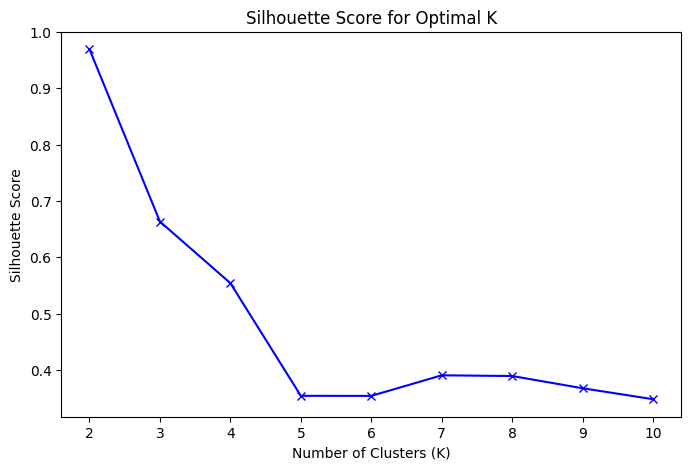

Optimal number of clusters based on silhouette score: 2


In [700]:
# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_list, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

# Display the best number of clusters
optimal_k = np.argmax(silhouette_list) + 2  # Add 2 because range starts at 2
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")


The Silhouette Score plot shows the optimal number of clusters (K) for customer segmentation. Key observations:

- The highest Silhouette Score is at K=2, indicating the strongest cluster separation with two groups
- There's a sharp decline in score from K=2 to K=5, suggesting diminishing returns with more clusters
- The score stabilizes around K=5-10 with minimal variation, indicating that additional clusters beyond 5 don't significantly improve the segmentation quality

Based on this analysis, while K=2 gives the mathematically optimal clustering, using 4 clusters is a reasonable choice as it provides more granular customer segmentation while maintaining meaningful cluster separation.

In [702]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_df = df_with_customer_id.copy()
kmeans_df['KMeans_Cluster'] = kmeans.fit_predict(rfm_df)

# Add cluster labels
print("KMeans Clustering Labels:")
kmeans_df['KMeans_Cluster'].value_counts()


KMeans Clustering Labels:


KMeans_Cluster
0    3710
3     599
2      24
1       4
Name: count, dtype: int64

**Identify customer profiles**

In [703]:
cluster_profiles = kmeans_df.groupby('KMeans_Cluster')[['XformRecency', 'XformFrequency', 'XformMonetary']].mean()
print(cluster_profiles)

                XformRecency  XformFrequency  XformMonetary
KMeans_Cluster                                             
0                   0.407876        0.047759      -0.129950
1                  -0.407143       70.077160       2.665691
2                  -0.292560       15.662037       1.798680
3                  -0.213129        3.037326       1.049338


| **Cluster** | **Label** | **Characteristics** | **Reasoning** |
| --- | --- | --- | --- |
| 0 | First-Time Customers | High Recency (0.41), Very Low Frequency (0.05), Negative Monetary (-0.13) | Recent first purchase with no prior history, typical of new customer acquisition |
| 1 | Premium Customers | High Negative Recency (-0.41), Very High Frequency (70.08), High Monetary (2.67) | Exceptional engagement levels with highest frequency and monetary value, representing top-tier customer base |
| 2 | High-Value Regular Customers | Moderate Negative Recency (-0.29), High Frequency (15.66), High Monetary (1.80) | Consistent high-value purchases with good engagement, forming stable revenue base |
| 3 | Declining Active Customers | Low Negative Recency (-0.21), Moderate Frequency (3.04), Moderate Monetary (1.05) | Showing signs of reduced engagement while maintaining some activity, potential for reactivation |

In [704]:
cluster_mapping = {0:	"First-Time Customers",
    1:	"Premium Customers",
    2:	"High-Value Regular Customers",
    3:	"Declining Active Customers"
}

In [705]:
# Map the cluster IDs to their descriptions
kmeans_df['Cluster_Description'] = kmeans_df['KMeans_Cluster'].replace(cluster_mapping)

In [706]:
def visualize_clusters_3d(data):
    """Visualize the clusters in 3D."""
    fig = px.scatter_3d(
        data, 
        x='XformRecency', 
        y='XformFrequency', 
        z='XformMonetary', 
        color='Cluster_Description', 
        title='Customer Clustering using RFM Score',
        labels={
            'XformRecency': 'Recency',     
            'XformFrequency': 'Frequency',   
            'XformMonetary': 'Monetary',    
            'Cluster_Description': 'Customer Segmentation'
        },
        hover_name='CustomerID'
    )
    
    fig.show()

In [707]:
visualize_clusters_3d(kmeans_df)

In [709]:
from IPython.display import Markdown

Markdown("![Alt Text](../resources/customer_segmentation_kmeans.png)")

![Alt Text](../resources/customer_segmentation_kmeans.png)